
<img src="https://bloqueneon.uniandes.edu.co/content/enforced/52233-202120_ISIS4219_01/Laboratorios.png?_&d2lSessionVal=guLBE9l4cI9Tip6PM5JSzKgp6&_&d2lSessionVal=iDtWjzbHb92iC3sVmHUqajJ2k&_&d2lSessionVal=g2xptlvZ5GrV3W5yGlhIgeBnN" ><br>
# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021



## Integrantes

*   Daniel Mateo Guatibonza Solano - 201611360
*   Raquel Andrea Cerda Montañez - 201533520
*   Sergio Eduardo Cárdenas Landazabal - 201613444



## **Problema**

Ante la situación actual de sanidad pública en el mundo a causa del COVID-19. La detección temprana de esta enfermedad en los pacientes, la automatización de procesos de diagnóstico y el apoyo a los diferentes expertos de esta enfermedad juega un papel muy importante para enfrentar una pandemia la cual ha registrado más de 230 millones de contagios, dejando sin vida a 4 millones de personas alrededor del mundo (OMS, 2021).

Sin embargo, todo este tiempo de cuarentena no solo ha servido para frenar la tasa de contagio del virus. También nos ha permitido recolectar diferentes radiografias de pacientes quienes han sufrido esta enfermedad, junto a otras enfermedades que pueden llegar a tener una confusión con la enfermedad provocada por el virus. Por ello, es importante determinar con exactitud el tipo de enfermedad para poder recomendar el mejor tratamiento para el paciente.

Se han recolectado alrededor de 21 mil imágenes provenientes de diferentes paises del medio oriente como Catar, Pakistan y Malasia. Y, ante la reactivación económica que se quiere llevar a cabo, se teme una nueva ola de contagios, por lo que poder identificar estos casos dadas sus radiografías automáticamente, sería de gran ayuda para los trabajadores de la Salud para determinar el tratamiento a los pacientes.

Para eso, le han pedido que construya un modelo capaz de recibir esas imágenes y determinar bajo qué probabilidad puede pertenecer a cada una de las clases de las enfermedades proporcionadas. Y así mismo determinar cuál sería el diagnóstico de ese paciente. Como sugerencia, le han pedido construir una Red Neuronal Artificial (ANN) la cual permita realizar este proceso de manera automática y sin supervisión de los expertos en el tema. 

Finalmente, ante la urgencia del problema, le han pedido que utilicen las imágenes en escala de grises para poder realizar una carga y un almacenamiento de manera más óptima, y utilizar directamente como entrada esta imagen.

**Fuente de Datos:** https://www.kaggle.com/preetviradiya/covid19-radiography-dataset

**Referencias:**

Coronavirus disease (COVID-19) – World Health Organization. (2021). Retrieved 5 October 2021, from https://www.who.int/emergencies/diseases/novel-coronavirus-2019?gclid=Cj0KCQjwwY-LBhD6ARIsACvT72PqduqyNWdB9YQ3awfqyC9FZ1y5Zy7srhp8wrVgEPPmzW4Jgll_Di8aAiDuEALw_wcB


## Librerías necesarias
En primer lugar, se importan todas las librerías requeridas para realizar la lectura, preprocesamiento y construcción de los modelos incluyendo las librerías requeridas para la selección de hiperparámetros.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import sys, random
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image, ImageOps

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.0-dev20211020


## Lectura de datos
Considerando el tipo de datos que se usarán como entrada, se utiliza la función que provee *keras* para cargar un dataset de imágenes dado el directorio principal donde estas se almacenan en carpetas con base en su clase. Así pues, en este punto se realiza la partición de entrenamiento y prueba, se especifica la dimensión de las imágenes (que originalmente corresponde a 299x299 píxeles), se define una carga incremental en batches de tamaño 32 y, de acuerdo a la recomendación dada, se efectúa la carga en escala de grises. Vale la pena mencionar que la partición fue hecha de forma que el conjunto de prueba constara del 20% del conjunto de datos y que las etiquetas fueran almacenadas como variables que representan una categoría.

In [2]:
batch_size = 32
img_height = 299
img_width = 299

data_dir = './COVID-19_Radiography_Dataset'

train_ds = tf.keras.utils.image_dataset_from_directory(
                    data_dir,
                    validation_split=0.2,
                    subset="training",
                    color_mode='grayscale',
                    label_mode='categorical',
                    seed=0,
                    image_size=(img_height, img_width),
                    batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(
                    data_dir,
                    validation_split=0.2,
                    subset="validation",
                    color_mode='grayscale',
                    label_mode='categorical',
                    seed=0,
                    image_size=(img_height, img_width),
                    batch_size=batch_size)
class_names = train_ds.class_names
print('Clases:', class_names)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.
Clases: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


## Exploración y descripción de los datos
Con el propósito de identificar la cantidad de datos por clase asociados a cada uno de los datasets cargados, se implementa una función que itera sobre las rutas del dataset y realiza este conteo. Adicionalmente, se almacenan en listas independientes las rutas de las imágenes en cada dataset por clase.

In [3]:
def contar_por_clase(ds):
    cant_covid, cant_normal, cant_lung_opacity, cant_viral_pneumonia = 0, 0, 0, 0
    paths_covid, paths_normal, paths_lung_opacity, paths_viral_pneumonia = [], [], [], []
    for ruta in ds.file_paths:
        if 'Normal' in ruta:
            paths_normal.append(ruta)
            cant_normal += 1
        elif 'Lung_Opacity' in ruta:
            paths_lung_opacity.append(ruta)
            cant_lung_opacity += 1
        elif 'Viral Pneumonia' in ruta:
            paths_viral_pneumonia.append(ruta)
            cant_viral_pneumonia += 1
        elif 'COVID' in ruta:
            paths_covid.append(ruta)
            cant_covid += 1
    print('COVID:', cant_covid)
    print('Normal:', cant_normal)
    print('Lung Opacity:', cant_lung_opacity)
    print('Viral Pneumonia:', cant_viral_pneumonia)
    return paths_covid, paths_normal, paths_lung_opacity, paths_viral_pneumonia

print('------------------------------------------------------------')
print('Cantidad de datos por clase en el conjunto de entrenamiento:')
train_paths_covid, train_paths_normal, train_paths_lung_opacity, train_paths_viral_pneumonia = contar_por_clase(train_ds)
print('------------------------------------------------------------')
print('Cantidad de datos por clase en el conjunto de prueba:')
test_paths_covid, test_paths_normal, test_paths_lung_opacity, test_paths_viral_pneumonia = contar_por_clase(test_ds)

------------------------------------------------------------
Cantidad de datos por clase en el conjunto de entrenamiento:
COVID: 2855
Normal: 8179
Lung Opacity: 4828
Viral Pneumonia: 1070
------------------------------------------------------------
Cantidad de datos por clase en el conjunto de prueba:
COVID: 761
Normal: 2013
Lung Opacity: 1184
Viral Pneumonia: 275


Por un lado, se observa que se cuenta con un caso desbalanceado donde la clase mayoritaria corresponde a las radiografías etiquetadas como normales, seguidas por las radiografías de pacientes con opacidad pulmonar, luego los que sufren de COVID y, por último, de forma minoritaria, a los que tienen neumonía viral. Por otro lado, se puede evidenciar que la funcionalidad de *keras* utilizada para la carga de datos mantiene la distribución de los datos entre los dos conjuntos.

A causa del desbalance evidenciado, se opta por hacer tanto submuestreo como sobremuestreo de los datos con el fin de atacar este problema. Considerando la limitante de memoria que implica utilizar este tipo de datos, se decidió que en este proceso se obtendrían 5000 imágenes por clase en el conjunto de entrenamiento lo que implica hacer submuestreo solo de las radiografías normales y sobremuestreo de las categorías restantes.

In [4]:
# Número de datos a seleccionar por clase.
cant_clase = 5000
# Semilla para obtener siempre el mismo muestreo.
random.seed(0)
# Submuestreo sobre la clase COVID para completar los 5000 datos
train_paths_covid = train_paths_covid + random.sample(train_paths_covid, cant_clase-len(train_paths_covid))
# Submuestreo sobre la clase Normal para obtener los 5000 datos
train_paths_normal = random.sample(train_paths_normal, cant_clase)
# Submuestreo sobre la clase Lung Opacity para completar los 5000 datos
train_paths_lung_opacity = train_paths_lung_opacity + random.sample(train_paths_lung_opacity, cant_clase-len(train_paths_lung_opacity))
# Submuestreo sobre la clase Viral Pneumonia para completar los 5000 datos
train_paths_viral_pneumonia = 4*train_paths_viral_pneumonia + random.sample(train_paths_viral_pneumonia, cant_clase-4*len(train_paths_viral_pneumonia))
# Generación de las listas de rutas balanceadas a partir de los conjuntos de tamaño 5000 obtenidos por clase
train_paths_balanced = train_paths_covid + train_paths_normal + train_paths_lung_opacity + train_paths_viral_pneumonia
test_paths = test_paths_covid + test_paths_normal + test_paths_lung_opacity + test_paths_viral_pneumonia

En este punto, fue necesario considerar que existe cierta incompatibilidad entre *tensorflow* y *sklearn* a la hora de realizar la búsqueda de hiperparámetros por medio de *RandomizedSearchCV*. En este sentido, no es posible utilizar los datasets cargados por medio de *keras* como entrada al entrenamiento de los modelos por lo que se procede a hacer la carga manual de cada imagen en memoria. En este caso, se realiza la transformación a la escala de grises directamente y la dimensión de las imágenes corresponde al tamaño original.

In [5]:
def cargar_imagenes(paths):
    X, y = [], []
    for ruta in paths:
        og_image = Image.open(ruta)
        gray_image = ImageOps.grayscale(og_image)
        img_data = np.array(gray_image)
        X.append(img_data)
        if 'Normal' in ruta:
            y.append('Normal')
        elif 'Lung_Opacity' in ruta:
            y.append('Lung Opacity')
        elif 'Viral Pneumonia' in ruta:
            y.append('Viral Pneumonia')
        elif 'COVID' in ruta:
            y.append('COVID')
    y = pd.get_dummies(y)
    return np.array(X), y.to_numpy()
X_train, y_train = cargar_imagenes(train_paths_balanced)
X_test, y_test = cargar_imagenes(test_paths)

Con el objetivo de validar la correcta carga de las radiografías, se ilustra una de estas de forma aleatoria.

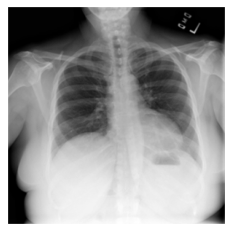

In [96]:
rand_index = random.randint(0, X_train.shape[0]-1)
fig = plt.imshow(X_train[rand_index,:,:], cmap = "gray");
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

## Construcción del modelo
Una vez cargados los datos, se construye una red neuronal base que consta de una capa oculta de 512 neuronas con activación *relu* y *dropout* de 0.5. Puesto que se desea utilizar cada imagen directamente como entrada a este tipo de modelo (ANN), se emplea también una capa que realiza la conversión de la imagen de una matriz a un vector.

In [6]:
model = Sequential()
model.add(Flatten(input_shape = (img_height, img_width)))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 89401)             0         
                                                                 
 dense (Dense)               (None, 512)               45773824  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
 activation_1 (Activation)   (None, 4)                 0         
                                                                 
Total params: 45,775,876
Trainable params: 45,775,876
No

Luego, se compila el modelo especificando el tipo de función de costo a minimizar, el optimizador *Adam* y que se desea evidenciar como métrica el *accuracy*. Posterior a ello, se define un criterio de parada del entrenamiento como un *callback* que realiza esto en caso de que entre 3 épocas no haya una disminución en la función de costo.

In [7]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

Después de compilar el modelo, este es entrenado al especificar los datos de entrenamiento y el criterio de parada definido; como se puede observar, a causa de esta última funcionalidad, el entrenamiento es realizado tan solo por 7 épocas aunque 100 son delimitadas. Adicionalmente, se obtiene un *accuracy* considerablemente bajo incluso teniendo cuatro categorías por lo que el paso a seguir es iterar sobre los hiperparámetros a fin de obtener un mejor modelo.

In [9]:
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, callbacks=callbacks)

Epoch 1/100
625/625 [==============================] - 103s 164ms/step - loss: 689.9141 - accuracy: 0.2675
Epoch 2/100
625/625 [==============================] - 102s 163ms/step - loss: 1.3956 - accuracy: 0.2466
Epoch 3/100
625/625 [==============================] - 103s 165ms/step - loss: 1.3904 - accuracy: 0.2453
Epoch 4/100
625/625 [==============================] - 101s 162ms/step - loss: 1.3863 - accuracy: 0.2494
Epoch 5/100
625/625 [==============================] - 101s 162ms/step - loss: 1.3864 - accuracy: 0.2472
Epoch 6/100
625/625 [==============================] - 102s 163ms/step - loss: 1.3864 - accuracy: 0.2476
Epoch 7/100
625/625 [==============================] - 102s 163ms/step - loss: 1.3864 - accuracy: 0.2438
Epoch 00007: early stopping


Así pues, se estructura una función que permitirá modificar los hiperparámetros de la red a construir. Lo anterior implica poder modificar el número de capas (de una a tres), la cantidad de neuronas por capa, la función de activación en cada una de ellas y el factor de *dropout*. De igual manera, se define el objeto de *sklearn* a partir de la clase *KerasClassifier* que permitirá efectuar la búsqueda de hiperparámetros.

In [10]:
def entrenar_red(nn1 = 512, nn2 = 100, nn3 = 25, n_layers= 3, dropout = 0.1, activacion_oculta = 'relu'):
    clf = Sequential(name='Mi_Red')
    clf.add(Flatten(input_shape=(img_height, img_width)))

    output = 4
    first = True
    
    num_neuronas = [nn1, nn2, nn3]
    for i in range(n_layers):
        clf.add(Dense(num_neuronas[i], activation=activacion_oculta, name='Capa_{}'.format(i)))
        clf.add(Dropout(dropout, name='Dropout_{}'.format(i)))
        
    clf.add(Dense(output, activation='softmax', name= 'Capa_Salida'))
    clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return clf

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=entrenar_red, epochs=100, verbose=1, shuffle=True)

Ahora bien, se define el *pipeline* y los valores de los hiperparámetros sobre los que se iterará así como la función que se desea mejorar entre modelos, en esta ocasión el *accuracy*. Después de esto, se define que la validación cruzada estará compuesta por tres particiones y que el número de modelos que aleatoriamente se desean evaluar corresponden a 25.

In [11]:
pipe = Pipeline([('red_neuronal', modelCV)])

param_grid = dict(red_neuronal__nn1 = [256, 512, 1024],
                  red_neuronal__nn2 = [32, 64, 128],
                  red_neuronal__nn3 = [4, 8, 16],
                  red_neuronal__n_layers = [1, 2, 3],
                  red_neuronal__dropout = [0.1, 0.2, 0.3],
                  red_neuronal__activacion_oculta = ['relu','sigmoid'])

def my_custom_acc(y_true, y_pred):
    return accuracy_score(y_true.argmax(axis=-1), y_pred)

score = make_scorer(my_custom_acc, greater_is_better=True)
grid = RandomizedSearchCV(pipe, param_grid, scoring=score, verbose=1, cv=3, n_iter=25, random_state=0)

Así pues, se procede a entrenar los 75 modelos (25 modelos x 3 particiones de validación) haciendo uso de nuevo del *callback* que permite detener la ejecución temprana de forma que este proceso no tome un tiempo exorbitante.

In [12]:
grid.fit(X_train, y_train, red_neuronal__batch_size=batch_size, red_neuronal__callbacks=callbacks)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Epoch 1/100
417/417 [==============================] - 67s 160ms/step - loss: 1185.4166 - accuracy: 0.6814
Epoch 2/100
417/417 [==============================] - 66s 159ms/step - loss: 5.2498 - accuracy: 0.7737
Epoch 3/100
417/417 [==============================] - 67s 161ms/step - loss: 0.4815 - accuracy: 0.8027
Epoch 4/100
417/417 [==============================] - 66s 159ms/step - loss: 0.4619 - accuracy: 0.8087
Epoch 5/100
417/417 [==============================] - 67s 161ms/step - loss: 0.4549 - accuracy: 0.8077
Epoch 6/100
417/417 [==============================] - 67s 160ms/step - loss: 0.4630 - accuracy: 0.8075
Epoch 7/100
417/417 [==============================] - 67s 161ms/step - loss: 0.6008 - accuracy: 0.7347
Epoch 8/100
417/417 [==============================] - 67s 161ms/step - loss: 0.6406 - accuracy: 0.7074
Epoch 00008: early stopping
Epoch 1/100
417/417 [==============================] - 68s 163ms/step - loss

417/417 [==============================] - 37s 90ms/step - loss: 1.0837 - accuracy: 0.3734
Epoch 00014: early stopping
Epoch 1/100
417/417 [==============================] - 38s 89ms/step - loss: 1.2812 - accuracy: 0.3745
Epoch 2/100
417/417 [==============================] - 37s 90ms/step - loss: 1.2630 - accuracy: 0.3731
Epoch 3/100
417/417 [==============================] - 37s 89ms/step - loss: 1.2615 - accuracy: 0.3700
Epoch 4/100
417/417 [==============================] - 37s 89ms/step - loss: 1.2606 - accuracy: 0.3715
Epoch 5/100
417/417 [==============================] - 38s 90ms/step - loss: 1.2591 - accuracy: 0.3743
Epoch 6/100
417/417 [==============================] - 37s 89ms/step - loss: 1.2588 - accuracy: 0.3755
Epoch 7/100
417/417 [==============================] - 37s 89ms/step - loss: 1.2595 - accuracy: 0.3767
Epoch 8/100
417/417 [==============================] - 37s 88ms/step - loss: 1.2581 - accuracy: 0.3683
Epoch 9/100
417/417 [==============================] - 37

417/417 [==============================] - 67s 161ms/step - loss: 1.0847 - accuracy: 0.3724
Epoch 15/100
417/417 [==============================] - 67s 161ms/step - loss: 1.0842 - accuracy: 0.3755
Epoch 16/100
417/417 [==============================] - 68s 162ms/step - loss: 1.0838 - accuracy: 0.3776
Epoch 17/100
417/417 [==============================] - 67s 161ms/step - loss: 1.0838 - accuracy: 0.3737
Epoch 18/100
417/417 [==============================] - 67s 160ms/step - loss: 1.0835 - accuracy: 0.3774
Epoch 19/100
417/417 [==============================] - 68s 163ms/step - loss: 1.0833 - accuracy: 0.3733
Epoch 20/100
417/417 [==============================] - 67s 160ms/step - loss: 1.0832 - accuracy: 0.3728
Epoch 21/100
417/417 [==============================] - 67s 161ms/step - loss: 1.0832 - accuracy: 0.3728
Epoch 22/100
417/417 [==============================] - 67s 160ms/step - loss: 1.0830 - accuracy: 0.3747
Epoch 23/100
417/417 [==============================] - 67s 161ms/st

417/417 [==============================] - 131s 314ms/step - loss: 1.0831 - accuracy: 0.3737
Epoch 23/100
417/417 [==============================] - 132s 316ms/step - loss: 1.0826 - accuracy: 0.3757
Epoch 24/100
417/417 [==============================] - 131s 315ms/step - loss: 1.0829 - accuracy: 0.3752
Epoch 25/100
417/417 [==============================] - 131s 314ms/step - loss: 1.0827 - accuracy: 0.3738
Epoch 26/100
417/417 [==============================] - 131s 314ms/step - loss: 1.0829 - accuracy: 0.3728
Epoch 00026: early stopping
Epoch 1/100
417/417 [==============================] - 129s 309ms/step - loss: 1.2927 - accuracy: 0.3812
Epoch 2/100
417/417 [==============================] - 130s 312ms/step - loss: 1.2671 - accuracy: 0.3740
Epoch 3/100
417/417 [==============================] - 130s 311ms/step - loss: 1.2614 - accuracy: 0.3746
Epoch 4/100
417/417 [==============================] - 132s 317ms/step - loss: 1.2610 - accuracy: 0.3769
Epoch 5/100
417/417 [==============

417/417 [==============================] - 130s 311ms/step - loss: 1.0830 - accuracy: 0.3741
Epoch 28/100
417/417 [==============================] - 130s 311ms/step - loss: 1.0828 - accuracy: 0.3736
Epoch 29/100
417/417 [==============================] - 130s 311ms/step - loss: 1.0827 - accuracy: 0.3755
Epoch 30/100
417/417 [==============================] - 130s 311ms/step - loss: 1.0826 - accuracy: 0.3733
Epoch 31/100
417/417 [==============================] - 131s 315ms/step - loss: 1.0825 - accuracy: 0.3691
Epoch 32/100
417/417 [==============================] - 132s 316ms/step - loss: 1.0825 - accuracy: 0.3691
Epoch 33/100
417/417 [==============================] - 129s 310ms/step - loss: 1.0824 - accuracy: 0.3701
Epoch 34/100
417/417 [==============================] - 130s 311ms/step - loss: 1.0823 - accuracy: 0.3730
Epoch 35/100
417/417 [==============================] - 130s 311ms/step - loss: 1.0823 - accuracy: 0.3754
Epoch 36/100
417/417 [==============================] - 130

Epoch 6/100
417/417 [==============================] - 132s 316ms/step - loss: 1.2538 - accuracy: 0.3710
Epoch 7/100
417/417 [==============================] - 130s 312ms/step - loss: 1.2538 - accuracy: 0.3776
Epoch 8/100
417/417 [==============================] - 130s 313ms/step - loss: 1.2539 - accuracy: 0.3761
Epoch 9/100
417/417 [==============================] - 132s 316ms/step - loss: 1.2537 - accuracy: 0.3731
Epoch 10/100
417/417 [==============================] - 131s 314ms/step - loss: 1.2546 - accuracy: 0.3719
Epoch 11/100
417/417 [==============================] - 131s 314ms/step - loss: 1.2540 - accuracy: 0.3751
Epoch 12/100
417/417 [==============================] - 132s 318ms/step - loss: 1.2539 - accuracy: 0.3751
Epoch 00012: early stopping
Epoch 1/100
417/417 [==============================] - 136s 324ms/step - loss: 1257.3536 - accuracy: 0.3916
Epoch 2/100
417/417 [==============================] - 136s 326ms/step - loss: 6.7855 - accuracy: 0.3724
Epoch 3/100
417/417 [

417/417 [==============================] - 69s 165ms/step - loss: 1.2577 - accuracy: 0.3746
Epoch 7/100
417/417 [==============================] - 73s 175ms/step - loss: 1.2572 - accuracy: 0.3727
Epoch 8/100
417/417 [==============================] - 69s 165ms/step - loss: 1.2566 - accuracy: 0.3719
Epoch 9/100
417/417 [==============================] - 69s 165ms/step - loss: 1.2562 - accuracy: 0.3695
Epoch 10/100
417/417 [==============================] - 71s 170ms/step - loss: 1.2560 - accuracy: 0.3752
Epoch 11/100
417/417 [==============================] - 68s 163ms/step - loss: 1.2556 - accuracy: 0.3730
Epoch 12/100
417/417 [==============================] - 68s 163ms/step - loss: 1.2557 - accuracy: 0.3717
Epoch 13/100
417/417 [==============================] - 68s 163ms/step - loss: 1.2559 - accuracy: 0.3782
Epoch 14/100
417/417 [==============================] - 68s 164ms/step - loss: 1.2558 - accuracy: 0.3737
Epoch 00014: early stopping
Epoch 1/100
417/417 [======================

417/417 [==============================] - 130s 313ms/step - loss: 0.9662 - accuracy: 0.5119
Epoch 8/100
417/417 [==============================] - 131s 313ms/step - loss: 0.9908 - accuracy: 0.5104
Epoch 9/100
417/417 [==============================] - 130s 313ms/step - loss: 0.9837 - accuracy: 0.5243
Epoch 00009: early stopping
Epoch 1/100
417/417 [==============================] - 130s 311ms/step - loss: 631.9645 - accuracy: 0.4005
Epoch 2/100
417/417 [==============================] - 130s 311ms/step - loss: 2.0094 - accuracy: 0.3707
Epoch 3/100
417/417 [==============================] - 130s 311ms/step - loss: 1.8096 - accuracy: 0.3742
Epoch 4/100
417/417 [==============================] - 130s 311ms/step - loss: 2.1983 - accuracy: 0.3712
Epoch 5/100
417/417 [==============================] - 130s 311ms/step - loss: 1.1899 - accuracy: 0.3755
Epoch 6/100
417/417 [==============================] - 130s 312ms/step - loss: 1.5168 - accuracy: 0.3677
Epoch 7/100
417/417 [================

417/417 [==============================] - 131s 314ms/step - loss: 1.1065 - accuracy: 0.3733
Epoch 9/100
417/417 [==============================] - 131s 315ms/step - loss: 1.1020 - accuracy: 0.3692
Epoch 10/100
417/417 [==============================] - 131s 315ms/step - loss: 1.0985 - accuracy: 0.3711
Epoch 11/100
417/417 [==============================] - 131s 315ms/step - loss: 1.0956 - accuracy: 0.3760
Epoch 12/100
417/417 [==============================] - 131s 315ms/step - loss: 1.0934 - accuracy: 0.3727
Epoch 13/100
417/417 [==============================] - 131s 314ms/step - loss: 1.0915 - accuracy: 0.3766
Epoch 14/100
417/417 [==============================] - 131s 314ms/step - loss: 1.0900 - accuracy: 0.3758
Epoch 15/100
417/417 [==============================] - 131s 314ms/step - loss: 1.0888 - accuracy: 0.3696
Epoch 16/100
417/417 [==============================] - 131s 315ms/step - loss: 1.0878 - accuracy: 0.3719
Epoch 17/100
417/417 [==============================] - 131s

417/417 [==============================] - 67s 161ms/step - loss: 1.0994 - accuracy: 0.3725
Epoch 14/100
417/417 [==============================] - 67s 160ms/step - loss: 1.0943 - accuracy: 0.3727
Epoch 15/100
417/417 [==============================] - 67s 160ms/step - loss: 1.0965 - accuracy: 0.3754
Epoch 16/100
417/417 [==============================] - 67s 160ms/step - loss: 1.0984 - accuracy: 0.3691
Epoch 17/100
417/417 [==============================] - 67s 160ms/step - loss: 1.0958 - accuracy: 0.3667
Epoch 00017: early stopping
Epoch 1/100
417/417 [==============================] - 131s 312ms/step - loss: 1.1731 - accuracy: 0.3541
Epoch 2/100
417/417 [==============================] - 130s 312ms/step - loss: 1.1473 - accuracy: 0.3539
Epoch 3/100
417/417 [==============================] - 130s 312ms/step - loss: 1.1297 - accuracy: 0.3542
Epoch 4/100
417/417 [==============================] - 130s 312ms/step - loss: 1.1176 - accuracy: 0.3627
Epoch 5/100
417/417 [===================

417/417 [==============================] - 67s 161ms/step - loss: 1.0823 - accuracy: 0.3728
Epoch 51/100
417/417 [==============================] - 68s 162ms/step - loss: 1.0823 - accuracy: 0.3688
Epoch 00051: early stopping
Epoch 1/100
417/417 [==============================] - 68s 161ms/step - loss: 123.3351 - accuracy: 0.3700
Epoch 2/100
417/417 [==============================] - 67s 162ms/step - loss: 1.7088 - accuracy: 0.3668
Epoch 3/100
417/417 [==============================] - 67s 161ms/step - loss: 2.1032 - accuracy: 0.3747
Epoch 4/100
417/417 [==============================] - 67s 160ms/step - loss: 1.2558 - accuracy: 0.3703
Epoch 5/100
417/417 [==============================] - 67s 160ms/step - loss: 1.3429 - accuracy: 0.3781
Epoch 6/100
417/417 [==============================] - 67s 161ms/step - loss: 1.2555 - accuracy: 0.3716
Epoch 7/100
417/417 [==============================] - 67s 161ms/step - loss: 1.2556 - accuracy: 0.3753
Epoch 8/100
417/417 [========================

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('red_neuronal',
                                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F960746688>)]),
                   n_iter=25,
                   param_distributions={'red_neuronal__activacion_oculta': ['relu',
                                                                            'sigmoid'],
                                        'red_neuronal__dropout': [0.1, 0.2,
                                                                  0.3],
                                        'red_neuronal__n_layers': [1, 2, 3],
                                        'red_neuronal__nn1': [256, 512, 1024],
                                        'red_neuronal__nn2': [32, 64, 128],
                                        'red_neuronal__nn3': [4, 8, 16]},
                   random_state=0, scoring=make_scorer(my_custom_acc),
                   verbose=1)

A lo largo del entrenamiento de los distintos modelos, se puede observar que en su mayoría ninguno logra alcanzar un *accuracy* superior a 0,4. No obstante, se procede a evaluar el mejor modelo que se obtuvo. Como se muestra a continuación, este consta de una sola capa oculta de 1024 neuronas con factor de *dropout* de 0,1 y función de activación *relu*.

In [13]:
best_model = grid.best_estimator_
print(best_model.get_params())
best_model['red_neuronal'].model.summary()

{'memory': None, 'steps': [('red_neuronal', <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F960802F88>)], 'verbose': False, 'red_neuronal': <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F960802F88>, 'red_neuronal__epochs': 100, 'red_neuronal__verbose': 1, 'red_neuronal__shuffle': True, 'red_neuronal__nn3': 4, 'red_neuronal__nn2': 64, 'red_neuronal__nn1': 1024, 'red_neuronal__n_layers': 1, 'red_neuronal__dropout': 0.1, 'red_neuronal__activacion_oculta': 'relu', 'red_neuronal__build_fn': <function entrenar_red at 0x000001F960554AF8>}
Model: "Mi_Red"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_76 (Flatten)        (None, 89401)             0         
                                                                 
 Capa_0 (Dense)              (None, 1024)              91547648  
                                                                 
 Dropout_0 (Dropo

## Evaluación e interpretación de resultados
Al evaluar los datos de entrenamiento, se obtuvo un *accuracy* de aproximadamente 1/4 que nuevamente es bajo aunque levemente mejor al del caso base. Al realizar este mismo procedimiento sobre los datos de prueba, se obtuvo una métrica de casi el doble del valor que con los datos de entrenamiento. 

In [74]:
y_pred_train = best_model.predict(X_train)

In [75]:
acc = my_custom_acc(y_train, y_pred_train)
print('Train Accuracy: {:4f}'.format(acc))

Train Accuracy: 0.250300


In [80]:
y_pred_test = best_model.predict(X_test)

In [81]:
acc = my_custom_acc(y_test, y_pred_test)
print('Test Accuracy: {:4f}'.format(acc))

Test Accuracy: 0.474132


Este patrón particular indica un comportamiento no deseado en los modelos entrenados por lo que se construye la matriz de confusión para evidenciar lo ocurrido.

Matriz de confusión sobre datos de entrenamiento


Text(54.213125000000005, 0.5, 'Etiquetas predichas')

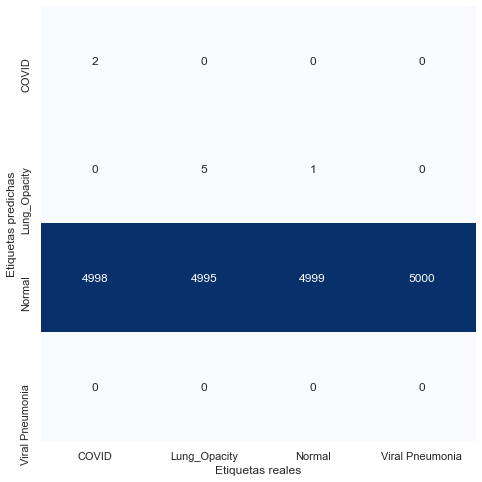

In [103]:
clases = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']
print("Matriz de confusión sobre datos de entrenamiento")
plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_train, y_pred_train)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=clases,
            yticklabels=clases)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')

Matriz de confusión sobre datos de prueba


Text(54.213125000000005, 0.5, 'Etiquetas predichas')

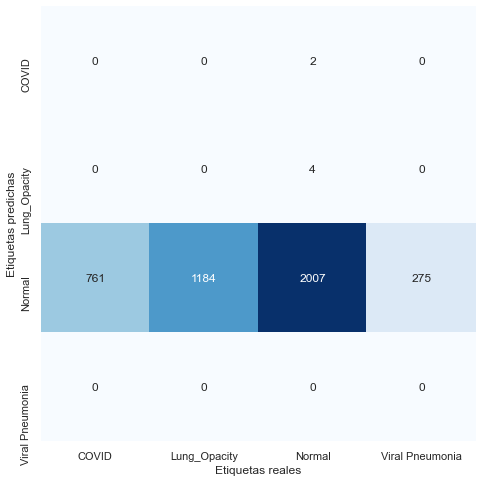

In [104]:
print("Matriz de confusión sobre datos de prueba")
plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred_test)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=clases,
            yticklabels=clases)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')

Tal como se evidencia en las matrices de confusión tanto de los datos de entrenamiento como de los de prueba, el modelo decide clasificar casi todos los datos como normales a pesar de que el entrenamiento fue desarrollado a partir de un conjunto balanceado. A continuación, se evidencia esto también sobre distintas métricas; aunque se obtiene un valor aceptable de la precisión para las clases COVID y Lung_Opacity en los datos de entrenamiento, esto se debe a la minoría de datos que se clasificaron en estas clases.

In [105]:
Y_train = y_train.argmax(axis=-1)
Y_test = y_test.argmax(axis=-1)
print('--------------------------------------------------------')
print('Reporte para el modelo sobre datos de entrenamiento')
print(classification_report(Y_train, y_pred_train, target_names=clases))
print('--------------------------------------------------------')
print('Reporte para el modelo sobre datos de prueba')
print(classification_report(Y_test, y_pred_test, target_names=clases))

--------------------------------------------------------
Reporte para el modelo sobre datos de entrenamiento
                 precision    recall  f1-score   support

          COVID       1.00      0.00      0.00      5000
   Lung_Opacity       0.83      0.00      0.00      5000
         Normal       0.25      1.00      0.40      5000
Viral Pneumonia       0.00      0.00      0.00      5000

       accuracy                           0.25     20000
      macro avg       0.52      0.25      0.10     20000
   weighted avg       0.52      0.25      0.10     20000

--------------------------------------------------------
Reporte para el modelo sobre datos de prueba
                 precision    recall  f1-score   support

          COVID       0.00      0.00      0.00       761
   Lung_Opacity       0.00      0.00      0.00      1184
         Normal       0.47      1.00      0.64      2013
Viral Pneumonia       0.00      0.00      0.00       275

       accuracy                           0

## Conclusión
El comportamiento evidenciado por parte de todos los modelos entrenados indica que, aunque se consideraron modelos de complejidad elevada respecto a la capacidad computacional disponible, estos no fueron capaces de generalizar el comportamiento de las imágenes de acuerdo a su categoría. Es decir, que utilizar cada uno de los píxeles como un *feature* de las imágenes no posibilita el aprendizaje en ninguno de los casos. Por tanto, aunque la organización desea un red neuronal artificial (ANN) como modelo, se recomendaría hacer uso de capas más complejas como las convolucionales (CNN) que permiten extrar características de las imágenes dado que el aplanamiento de las mismas no resulta viable. 